In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

trainDataSet = pd.read_csv('train.csv')
testDataSet = pd.read_csv('test.csv')
trainDataSet.head
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print (trainDataSet.shape)
print (testDataSet.shape)
print (trainDataSet.columns)
trainDataSet.tail()

(159571, 8)
(153164, 2)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [3]:
def cleanText(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    return text

In [4]:
for className in class_names:
    print (trainDataSet[className].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [5]:
print('Percentage of comments that are not labelled:')
print(len(trainDataSet[(trainDataSet['toxic']==0) & 
             (trainDataSet['severe_toxic']==0) & 
             (trainDataSet['obscene']==0) & 
             (trainDataSet['threat']== 0) & 
             (trainDataSet['insult']==0) &
             (trainDataSet['identity_hate']==0)]) / len(trainDataSet))

Percentage of comments that are not labelled:
0.8983211235124177


In [6]:
tempToxicDataSet = trainDataSet[trainDataSet['toxic'] == 0][0:1]
tempInsultDataSet = trainDataSet[trainDataSet['toxic'] == 1][0:1]
frames = [tempToxicDataSet, tempInsultDataSet]
tempTrainDataSet = pd.concat(frames)
print (tempTrainDataSet.shape)

tempTestDataSet = testDataSet[0:1]
print (tempTestDataSet.shape)

(2, 8)
(1, 2)


In [7]:
train_text = tempTrainDataSet['comment_text']
train_target = tempTrainDataSet.loc[:, class_names]
test_text = tempTestDataSet['comment_text']
all_text = pd.concat([train_text, test_text])
StringData = ""
for i in all_text:
    StringData += i
StringData

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27COCKSUCKER BEFORE YOU PISS AROUND ON MY WORKYo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

|### SENT TOKENIZE - Convert the paragraph into sentences
### WORD TOKENIZE - Convert a sentence or paragraph into words

In [8]:
print ("Original Text - ",StringData,"\n")
sentences = nltk.sent_tokenize(StringData)
print (len(sentences))
sentences

Original Text -  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27COCKSUCKER BEFORE YOU PISS AROUND ON MY WORKYo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time., 

6


['Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted?',
 "They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC.",
 "And please don't remove the template from the talk page since I'm retired now.89.205.38.27COCKSUCKER BEFORE YOU PISS AROUND ON MY WORKYo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me.",
 'Ja rule is about pride in da music man.',
 'dont diss that shit on him.',
 'and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,']

In [9]:
words = nltk.word_tokenize(StringData)
print (len(words))
words

136


['Explanation',
 'Why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'Hardcore',
 'Metallica',
 'Fan',
 'were',
 'reverted',
 '?',
 'They',
 'were',
 "n't",
 'vandalisms',
 ',',
 'just',
 'closure',
 'on',
 'some',
 'GAs',
 'after',
 'I',
 'voted',
 'at',
 'New',
 'York',
 'Dolls',
 'FAC',
 '.',
 'And',
 'please',
 'do',
 "n't",
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk',
 'page',
 'since',
 'I',
 "'m",
 'retired',
 'now.89.205.38.27COCKSUCKER',
 'BEFORE',
 'YOU',
 'PISS',
 'AROUND',
 'ON',
 'MY',
 'WORKYo',
 'bitch',
 'Ja',
 'Rule',
 'is',
 'more',
 'succesful',
 'then',
 'you',
 "'ll",
 'ever',
 'be',
 'whats',
 'up',
 'with',
 'you',
 'and',
 'hating',
 'you',
 'sad',
 'mofuckas',
 '...',
 'i',
 'should',
 'bitch',
 'slap',
 'ur',
 'pethedic',
 'white',
 'faces',
 'and',
 'get',
 'you',
 'to',
 'kiss',
 'my',
 'ass',
 'you',
 'guys',
 'sicken',
 'me',
 '.',
 'Ja',
 'rule',
 'is',
 'about',
 'pride',
 'in',
 'da',
 'music',
 'man',
 '.',
 'dont',
 'diss',
 

#### STEMMING - Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).
#### Example - (Intelligence or Intelligently => Intelligen)
#### Problem - Produced intermediate representation of the word may not have any meaning 
#### LEMMATIZATION - Same as stemming but the intermediate representation has a meaning
#### Example - (Intelligence or Intelligently => Intelligent)

In [10]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in range(len(sentences)):
    print ("Actual Sentence - ",sentences[i],"\n")
    stemmingWords = nltk.word_tokenize(sentences[i])
    lemmatizingWords = nltk.word_tokenize(sentences[i])
    stemmedWords = [stemmer.stem(word) for word in stemmingWords]
    lemmatizedWords = [lemmatizer.lemmatize(word) for word in lemmatizingWords]
    print ("Stemmed Words - \n")
    print (stemmedWords)
    print ("Lemmatized Words - \n")
    print (lemmatizedWords)
    print ("____________________________________________")

Actual Sentence -  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? 

Stemmed Words - 

['explan', 'whi', 'the', 'edit', 'made', 'under', 'my', 'usernam', 'hardcor', 'metallica', 'fan', 'were', 'revert', '?']
Lemmatized Words - 

['Explanation', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'were', 'reverted', '?']
____________________________________________
Actual Sentence -  They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. 

Stemmed Words - 

['they', 'were', "n't", 'vandal', ',', 'just', 'closur', 'on', 'some', 'ga', 'after', 'I', 'vote', 'at', 'new', 'york', 'doll', 'fac', '.']
Lemmatized Words - 

['They', 'were', "n't", 'vandalism', ',', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'voted', 'at', 'New', 'York', 'Dolls', 'FAC', '.']
____________________________________________
Actual Sentence -  And please don't remove the template from the talk page si

### REMOVAL OF STOP WORDS
### Example - (to, be etc....)
### Stopwords are not required while doing sentiment analysis and we need to carry out this step for better performance

In [11]:
from nltk.corpus import stopwords

for i in range(len(sentences)):
    print ("Actual Sentence - ",sentences[i],"\n")
    words = nltk.word_tokenize(sentences[i])
    newwords = [word for word in words if word not in stopwords.words('english')]
    print (newwords)
    print ("____________________________________________")

Actual Sentence -  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? 

['Explanation', 'Why', 'edits', 'made', 'username', 'Hardcore', 'Metallica', 'Fan', 'reverted', '?']
____________________________________________
Actual Sentence -  They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. 

['They', "n't", 'vandalisms', ',', 'closure', 'GAs', 'I', 'voted', 'New', 'York', 'Dolls', 'FAC', '.']
____________________________________________
Actual Sentence -  And please don't remove the template from the talk page since I'm retired now.89.205.38.27COCKSUCKER BEFORE YOU PISS AROUND ON MY WORKYo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. 

['And', 'please', "n't", 'remove', 'template', 'talk', 'page', 'since', 'I', "'m", 'retired', 'now.89.205.38.27COCKSUCKER', 'BEFORE', 'YOU', 

### PARTS OF SPEECH TAGGING

In [12]:
words = nltk.word_tokenize(StringData)
tagged_words = nltk.pos_tag(words)
words_tags = []
for tw in tagged_words:
    words_tags.append(tw[0]+"_"+tw[1])
print (words_tags)

['Explanation_NN', 'Why_WRB', 'the_DT', 'edits_NNS', 'made_VBN', 'under_IN', 'my_PRP$', 'username_JJ', 'Hardcore_NNP', 'Metallica_NNP', 'Fan_NNP', 'were_VBD', 'reverted_VBN', '?_.', 'They_PRP', 'were_VBD', "n't_RB", 'vandalisms_JJ', ',_,', 'just_RB', 'closure_NN', 'on_IN', 'some_DT', 'GAs_NNP', 'after_IN', 'I_PRP', 'voted_VBD', 'at_IN', 'New_NNP', 'York_NNP', 'Dolls_NNP', 'FAC_NNP', '._.', 'And_CC', 'please_VB', 'do_VBP', "n't_RB", 'remove_VB', 'the_DT', 'template_NN', 'from_IN', 'the_DT', 'talk_NN', 'page_NN', 'since_IN', 'I_PRP', "'m_VBP", 'retired_JJ', 'now.89.205.38.27COCKSUCKER_NN', 'BEFORE_IN', 'YOU_NNP', 'PISS_NNP', 'AROUND_NNP', 'ON_NNP', 'MY_NNP', 'WORKYo_NNP', 'bitch_NN', 'Ja_NNP', 'Rule_NNP', 'is_VBZ', 'more_RBR', 'succesful_JJ', 'then_RB', 'you_PRP', "'ll_MD", 'ever_RB', 'be_VB', 'whats_VBN', 'up_RP', 'with_IN', 'you_PRP', 'and_CC', 'hating_VBG', 'you_PRP', 'sad_JJ', 'mofuckas_NNS', '..._:', 'i_NN', 'should_MD', 'bitch_VB', 'slap_NN', 'ur_JJ', 'pethedic_JJ', 'white_JJ', 'fa

### NAMED ENTITY RECOGNITION

In [13]:
import matplotlib

words = nltk.word_tokenize(StringData)
tagged_words = nltk.pos_tag(words)
namedEntity = nltk.ne_chunk(tagged_words)
print (namedEntity)

(S
  (GPE Explanation/NN)
  Why/WRB
  the/DT
  edits/NNS
  made/VBN
  under/IN
  my/PRP$
  username/JJ
  (ORGANIZATION Hardcore/NNP)
  (ORGANIZATION Metallica/NNP)
  Fan/NNP
  were/VBD
  reverted/VBN
  ?/.
  They/PRP
  were/VBD
  n't/RB
  vandalisms/JJ
  ,/,
  just/RB
  closure/NN
  on/IN
  some/DT
  GAs/NNP
  after/IN
  I/PRP
  voted/VBD
  at/IN
  (GPE New/NNP York/NNP)
  (PERSON Dolls/NNP FAC/NNP)
  ./.
  And/CC
  please/VB
  do/VBP
  n't/RB
  remove/VB
  the/DT
  template/NN
  from/IN
  the/DT
  talk/NN
  page/NN
  since/IN
  I/PRP
  'm/VBP
  retired/JJ
  now.89.205.38.27COCKSUCKER/NN
  BEFORE/IN
  (ORGANIZATION YOU/NNP)
  PISS/NNP
  AROUND/NNP
  ON/NNP
  MY/NNP
  WORKYo/NNP
  bitch/NN
  Ja/NNP
  Rule/NNP
  is/VBZ
  more/RBR
  succesful/JJ
  then/RB
  you/PRP
  'll/MD
  ever/RB
  be/VB
  whats/VBN
  up/RP
  with/IN
  you/PRP
  and/CC
  hating/VBG
  you/PRP
  sad/JJ
  mofuckas/NNS
  .../:
  i/NN
  should/MD
  bitch/VB
  slap/NN
  ur/JJ
  pethedic/JJ
  white/JJ
  faces/VBZ
  and/CC
  


### BAG OF WORDS MODEL
### The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms.
### Study Link  - https://machinelearningmastery.com/gentle-introduction-bag-words-model/


1. Convert all letters to lower case
1. Remove all special characters
1. Remove all extra spaces

In [14]:
import re

sentences = nltk.sent_tokenize(StringData)
for i in range(len(sentences)):
    sentences[i] = sentences[i].lower()
    sentences[i] = re.sub(r'\W',' ',sentences[i])
    sentences[i] = re.sub(r'\s+',' ',sentences[i])
sentences

['explanation why the edits made under my username hardcore metallica fan were reverted ',
 'they weren t vandalisms just closure on some gas after i voted at new york dolls fac ',
 'and please don t remove the template from the talk page since i m retired now 89 205 38 27cocksucker before you piss around on my workyo bitch ja rule is more succesful then you ll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ',
 'ja rule is about pride in da music man ',
 'dont diss that shit on him ',
 'and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time ']

### 1. Create the word count dictionary
### 2. Get the first 5 frequently occuring words.

In [15]:
word2count = {}
for data in sentences:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1
import heapq
freq_words = heapq.nlargest(30, word2count, key=word2count.get)
freq_words

['you',
 'and',
 'the',
 'my',
 'on',
 'i',
 'is',
 't',
 'bitch',
 'ja',
 'rule',
 'white',
 'get',
 'explanation',
 'why',
 'edits',
 'made',
 'under',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 'they',
 'weren',
 'vandalisms',
 'just',
 'closure',
 'some']

### Create the bag of words model

In [16]:
bagOfWords = []
for data in sentences:
    vector = []
    for word in freq_words:
        if word in nltk.word_tokenize(data):
            vector.append(1)
        else:
            vector.append(0)
    bagOfWords.append(vector)
bagOfWords = np.asarray(bagOfWords)
bagOfWords

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

### Drawbacks of Bag Of Words model -
### 1.  All words have same importance. 
### 2. No semantic information is preserved
### Solution to the above problems is - TF-IDF model (Term Frequency - Inverse Document Frequency )
### TF-IDF = (Number of occurences of word in the document / Total Number of words in a document)


In [17]:
# IDF Matrix
word_idfs = {}
for word in freq_words:
    document_count = 0
    for data in sentences:
        if word in nltk.word_tokenize(data):
            document_count += 1
    word_idfs[word] = np.log((len(sentences)/document_count)+1) # +1 is the bias and standard way of calulating TF-IDF
word_idfs

{'you': 1.9459101490553132,
 'and': 1.3862943611198906,
 'the': 1.3862943611198906,
 'my': 1.3862943611198906,
 'on': 1.0986122886681098,
 'i': 1.3862943611198906,
 'is': 1.0986122886681098,
 't': 1.3862943611198906,
 'bitch': 1.9459101490553132,
 'ja': 1.3862943611198906,
 'rule': 1.3862943611198906,
 'white': 1.3862943611198906,
 'get': 1.3862943611198906,
 'explanation': 1.9459101490553132,
 'why': 1.9459101490553132,
 'edits': 1.9459101490553132,
 'made': 1.9459101490553132,
 'under': 1.9459101490553132,
 'username': 1.9459101490553132,
 'hardcore': 1.9459101490553132,
 'metallica': 1.9459101490553132,
 'fan': 1.9459101490553132,
 'were': 1.9459101490553132,
 'reverted': 1.9459101490553132,
 'they': 1.9459101490553132,
 'weren': 1.9459101490553132,
 'vandalisms': 1.9459101490553132,
 'just': 1.9459101490553132,
 'closure': 1.9459101490553132,
 'some': 1.9459101490553132}

In [18]:
# TF Matrix
tf_matrix = {}
for word in freq_words:
    doc_tf = []
    for data in sentences:
        frequency = 0
        for w in nltk.word_tokenize(data):
            if w == word:
                frequency += 1
        tf_word = frequency/len(nltk.word_tokenize(data))
        doc_tf.append(tf_word)
    tf_matrix[word] = doc_tf
# tf_matrix

In [19]:
# TF_IDF MATRIX
tfidf_matrix = []
for word in tf_matrix.keys():
    tfidf = []
    for value in tf_matrix[word]:
        score = value * word_idfs[word]
        tfidf.append(score)
    tfidf_matrix.append(tfidf)
tfidf_matrix

[[0.0, 0.0, 0.17690092264139212, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.06301338005090412, 0.0, 0.0, 0.06931471805599453],
 [0.10663802777845313, 0.0, 0.04200892003393608, 0.0, 0.0, 0.0],
 [0.10663802777845313, 0.0, 0.04200892003393608, 0.0, 0.0, 0.0],
 [0.0,
  0.06462425227459469,
  0.016645640737395603,
  0.0,
  0.1831020481113516,
  0.0],
 [0.0, 0.08154672712469944, 0.04200892003393608, 0.0, 0.0, 0.0],
 [0.0,
  0.0,
  0.016645640737395603,
  0.12206803207423442,
  0.0,
  0.054930614433405495],
 [0.0, 0.08154672712469944, 0.02100446001696804, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.058966974213797374, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.02100446001696804, 0.15403270679109896, 0.0, 0.0],
 [0.0, 0.0, 0.02100446001696804, 0.15403270679109896, 0.0, 0.0],
 [0.0, 0.0, 0.02100446001696804, 0.0, 0.0, 0.06931471805599453],
 [0.0, 0.0, 0.02100446001696804, 0.0, 0.0, 0.06931471805599453],
 [0.14968539608117795, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.14968539608117795, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.14968539608117795, 0.0, 0.0, 0

In [20]:
X = np.asarray(tfidf_matrix)
X = np.transpose(X)
X.shape

(6, 30)

####  N-GRAM MODEL - Need to know the Markov chains.  An n-gram is a contiguous sequence of n items from a given sample of text or speech. N-grams of texts are extensively used in text mining and natural language processing tasks. They are basically a set of co-occuring words within a given window and when computing the n-grams you typically move one word forward (although you can move X words forward in more advanced scenarios). For example, for the sentence "The cow jumps over the moon". If N=2 (known as bigrams), then the ngrams would be:
* the cow
* cow jumps
* jumps over
* over the
* the moon

#### Generating a word n-gram in the given code

In [21]:
import random

text = train_text[0]
words = nltk.word_tokenize(text)
print (text)
print ("\n")
ngrams = {}
n = 3
for i in range(len(words) - n):
    gram = ' '.join(words[i:i+n])
    if gram not in ngrams.keys():
        ngrams[gram] = []
    ngrams[gram].append(words[i+n])

currentgram = ' '.join(words[0:n])
result = currentgram
for i in range(10):
    if currentgram not in ngrams.keys():
        break
    possibilities = ngrams[currentgram]
    nextItem = possibilities[random.randrange(len(possibilities))]
    result  += ' '+nextItem
    rwords = nltk.word_tokenize(result)
    currentGram = ' '.join(rwords[len(rwords)-n:len(rwords)])
    
print (ngrams)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


{'Explanation Why the': ['edits'], 'Why the edits': ['made'], 'the edits made': ['under'], 'edits made under': ['my'], 'made under my': ['username'], 'under my username': ['Hardcore'], 'my username Hardcore': ['Metallica'], 'username Hardcore Metallica': ['Fan'], 'Hardcore Metallica Fan': ['were'], 'Metallica Fan were': ['reverted'], 'Fan were reverted': ['?'], 'were reverted ?': ['They'], 'reverted ? They': ['were'], '? They were': ["n't"], "They were n't": ['vandalisms'], "were n't vandalisms": [','], "n't vandalisms ,": ['just'], 'vandalisms , just': ['closure'], ', just closure': ['on'], 'just closure on': ['some'], 'closure on some': ['GAs'], 'on some GAs': ['after'], 'some GAs after': ['I'], 'GAs after I': ['voted'], 

## LATENT SYMANTIC ANALYSIS (LSA) - Latent Semantic Analysis is a technique for creating a vector representation of a document. Having a vector representation of a document gives you a way to compare documents for their similarity by calculating the distance between the vectors. This in turn means you can do handy things like classifying documents to determine which of a set of known topics they most likely belong to.
#### We need to build SVD model . SVD - Singular Value Decomposition. Refer to the link for more information - https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
#### LSA  is used for following applications:
#### 1.  Article Bucketing in websites
#### 2. Finding relationships between articles/words
#### 3. Page indexing in search engines

In [22]:
from sklearn.decomposition import TruncatedSVD

dataset = ["The amount of population is increasing day by day",
           "The concert was great",
           "I love to see Gordan Ramsay cook",
           "Google is introducing a new technology",
           "AI Robots are the example of great technology present today",
           "All of us were singing in the concert",
           "We have launch campaigns to stop pollution and global warming"
          ]
dataset = [line.lower() for line in dataset]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset)
#print (X[0]) # (documentNumber , position) tfidf value

lsa = TruncatedSVD(n_components = 4, n_iter = 100) # n_components are the number of concepts that you want to find from the data
lsa.fit(X)
#print (lsa.components_[3])
terms = vectorizer.get_feature_names()
concept_words = {}
for i,comp in enumerate(lsa.components_):
    componentTerms = zip(terms,comp)
    sortedTerms = sorted(componentTerms, key=lambda x:x[1], reverse=True)
    sortedTerms =  sortedTerms[:10]
    concept_words["Concept "+str(i)] = sortedTerms

for key in concept_words.keys():
    sentence_scores = []
    for sentence in dataset:
        words = nltk.word_tokenize(sentence)
        score = 0
        for word in words:
            for word_with_score in concept_words[key]:
                if word == word_with_score[0]:
                    score += word_with_score[1]
        sentence_scores.append(score)
    print("\n"+key+"\n")
    for sent_score in sentence_scores:
        print (sent_score)


Concept 0

1.0845533846505304
1.4149255370850633
0
0.18758805859317684
1.245764829907757
1.5582745459910927
0

Concept 1

0
0
1.8337467336425444
0
0
0
1.2850142324187057

Concept 2

1.4095117867129112
0
0
1.7814528740758675
0.32831802736015747
0
0

Concept 3

2.1306513775604543
0
0
0
0.1303202816189605
0.6110485555266367
0


#### Find the synonyms and antonyms for words - Refer to link - https://wordnet.princeton.edu/

In [25]:
'''
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud().generate(StringData)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
'''

'\nimport matplotlib.pyplot as plt\nfrom wordcloud import WordCloud\n\nwc = WordCloud().generate(StringData)\nplt.figure(figsize=(15,15))\nplt.imshow(wc, interpolation=\'bilinear\')\nplt.axis("off")\nplt.show()\n'

In [26]:
from nltk.corpus import wordnet

synonyms = []
antonyms = []

for syn in wordnet.synsets("good"):
    for s in syn.lemmas():
        synonyms.append(s.name())
        for a in s.antonyms():
            antonyms.append(a.name())
print (set(antonyms))
print (set(synonyms))

{'badness', 'evilness', 'ill', 'bad', 'evil'}
{'just', 'sound', 'commodity', 'dear', 'upright', 'salutary', 'thoroughly', 'skillful', 'honest', 'right', 'proficient', 'respectable', 'secure', 'honorable', 'good', 'near', 'safe', 'undecomposed', 'well', 'beneficial', 'unspoilt', 'expert', 'in_force', 'adept', 'effective', 'dependable', 'in_effect', 'goodness', 'trade_good', 'estimable', 'ripe', 'full', 'unspoiled', 'skilful', 'practiced', 'serious', 'soundly'}


In [27]:
from nltk.corpus import stopwords
import string
import re

oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = trainDataSet['comment_text'].values
cleanedSentences = ""
for i in range(0,10000):
    cleanedText = cleanText(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

'''
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
'''

[('article', 3538), ('page', 2964), ('wikipedia', 2868), ('would', 2356), ('talk', 2240), ('one', 1902), ('like', 1855), ('please', 1774), ('see', 1380), ('also', 1312), ('know', 1230), ('think', 1218), ('edit', 1164), ('people', 1133), ('use', 1073), ('time', 993), ('fuck', 969), ('articles', 967), ('may', 942), ('user', 926), ('thanks', 889), ('go', 873), ('get', 861), ('even', 854), ('balls', 850), ('could', 846), ('make', 821), ('good', 808), ('information', 802), ('well', 784), ('ass', 759), ('sex', 740), ('deletion', 734), ('wp', 718), ('want', 708), ('first', 704), ('image', 699), ('way', 699), ('sources', 696), ('made', 687), ('name', 677), ('going', 674), ('new', 672), ('say', 668), ('pages', 663), ('source', 645), ('hate', 629), ('used', 628), ('really', 626), ('section', 625)]


'\nwc = WordCloud().generate(cleanedSentences)\nplt.figure(figsize=(15,15))\nplt.imshow(wc, interpolation=\'bilinear\')\nplt.axis("off")\nplt.show()\n'

In [28]:
import string
print (string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [29]:
tempNonToxicDataSet = trainDataSet[trainDataSet['toxic'] == 0][0:1000]
tempToxicDataSet = trainDataSet[trainDataSet['toxic'] == 1][0:1000]

tempNonSevereToxicDataSet = trainDataSet[trainDataSet['severe_toxic'] == 0][0:1000]
tempSevereToxicDataSet = trainDataSet[trainDataSet['severe_toxic'] == 1][0:1000]

tempNonObsceneDataSet = trainDataSet[trainDataSet['obscene'] == 0][0:1000]
tempObsceneDataSet = trainDataSet[trainDataSet['obscene'] == 1][0:1000]

tempNonThreadDataSet = trainDataSet[trainDataSet['threat'] == 0][0:1000]
tempThreadDataSet = trainDataSet[trainDataSet['threat'] == 1][0:1000]

tempNonInsultDataSet = trainDataSet[trainDataSet['insult'] == 0][0:1000]
tempInsultDataSet = trainDataSet[trainDataSet['insult'] == 1][0:1000]

tempNonIdentityHateDataSet = trainDataSet[trainDataSet['identity_hate'] == 0][0:1000]
tempIdentityHateDataSet = trainDataSet[trainDataSet['identity_hate'] == 1][0:1000]

frames = [tempNonToxicDataSet, tempToxicDataSet, 
          tempNonSevereToxicDataSet, tempSevereToxicDataSet, 
          tempNonObsceneDataSet, tempObsceneDataSet,
         tempNonThreadDataSet, tempThreadDataSet,
         tempNonInsultDataSet,tempInsultDataSet,
         tempNonIdentityHateDataSet , tempIdentityHateDataSet]
tempTrainDataSet = pd.concat(frames)
print (tempTrainDataSet.columns)

tempTestDataSet = testDataSet[0:1]
print (tempTestDataSet.shape)
tempTrainDataSet['comment_text'] = tempTrainDataSet['comment_text'].map(lambda com : cleanText(com))
tempTestDataSet['comment_text'] = tempTestDataSet['comment_text'].map(lambda com : cleanText(com))

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
(1, 2)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(tempTrainDataSet, random_state=42, test_size=0.2, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
testDataSet = tempTestDataSet.comment_text
print(X_train.shape)
print(X_test.shape)
print (testDataSet.shape)

(9182,)
(2296,)
(1,)


Processing for -- toxic
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.94      0.97      0.95      1173
          1       0.97      0.93      0.95      1123

avg / total       0.95      0.95      0.95      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  99.40781159991113 % toxic


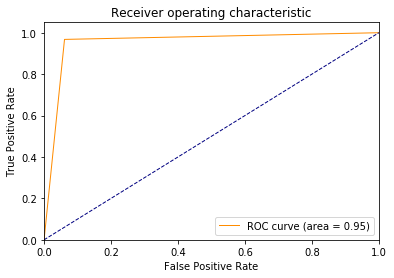

___________________________________________


Processing for -- severe_toxic
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.87      0.99      0.93      1916
          1       0.90      0.23      0.37       380

avg / total       0.87      0.87      0.83      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  9.955103281403648 % severe_toxic


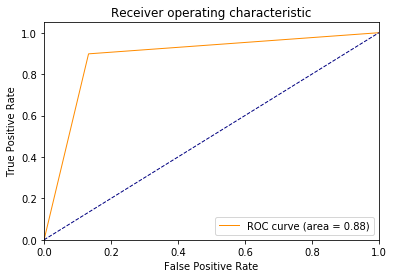

___________________________________________


Processing for -- obscene
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1429
          1       0.92      0.88      0.90       867

avg / total       0.93      0.93      0.93      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  98.14610411391762 % obscene


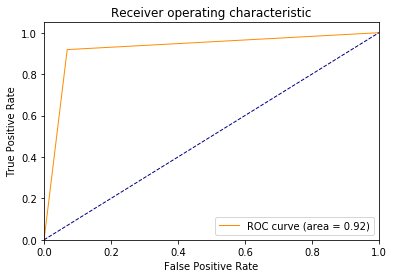

___________________________________________


Processing for -- threat
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2172
          1       0.00      0.00      0.00       124

avg / total       0.89      0.95      0.92      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  0.6760695841889963 % threat


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


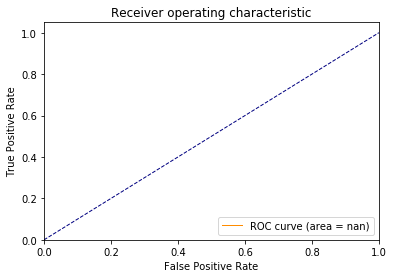

___________________________________________


Processing for -- insult
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.91      0.93      0.92      1428
          1       0.88      0.84      0.86       868

avg / total       0.89      0.89      0.89      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  96.84143004906598 % insult


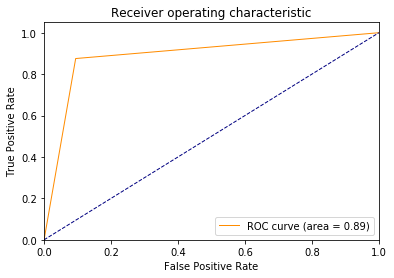

___________________________________________


Processing for -- identity_hate
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.89      1.00      0.94      1982
          1       0.97      0.23      0.37       314

avg / total       0.90      0.89      0.86      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  26.569925863963157 % identity_hate


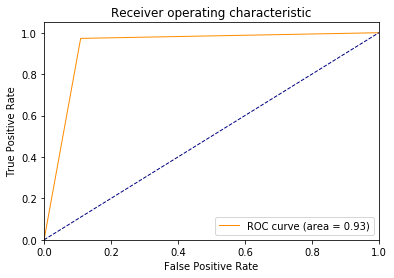

___________________________________________




In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

sentenceProbabilities = {}
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in class_names:
    print('Processing for --', category)
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    print ("Following is the Classification report - ")
    print(classification_report(test[category], prediction))
    probabilities = NB_pipeline.predict_proba(testDataSet)
    print ("Testing Comment --- ", testDataSet[0] )
    print ("The above testing comment is " ,probabilities[0][1] * 100,"%", category)
    fpr, tpr, thresholds = roc_curve(prediction, test[category])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw=1
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print ("___________________________________________")
    print ("\n")

Processing for ----  toxic
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1173
          1       0.98      0.97      0.97      1123

avg / total       0.98      0.98      0.98      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  99.99678188650749 % toxic


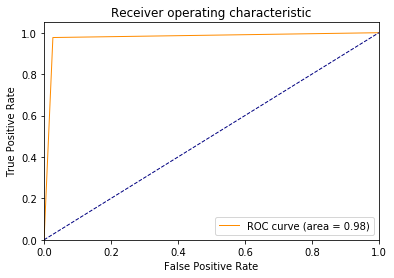

___________________________________________


Processing for ----  severe_toxic
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      1916
          1       0.88      0.75      0.81       380

avg / total       0.94      0.94      0.94      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  12.809997950362586 % severe_toxic


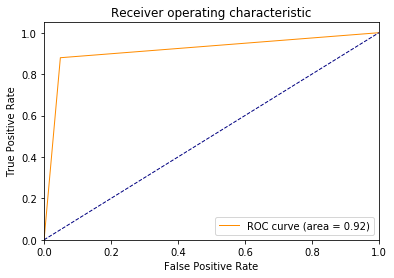

___________________________________________


Processing for ----  obscene
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1429
          1       0.95      0.96      0.95       867

avg / total       0.97      0.97      0.97      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  99.98696840921252 % obscene


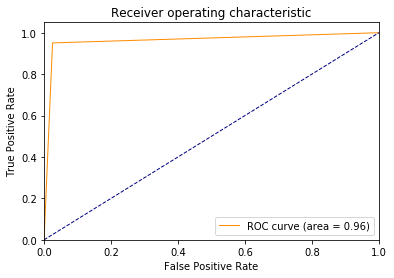

___________________________________________


Processing for ----  threat
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2172
          1       0.91      0.85      0.88       124

avg / total       0.99      0.99      0.99      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  5.271249450358238 % threat


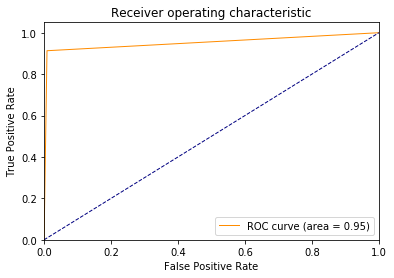

___________________________________________


Processing for ----  insult
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      1428
          1       0.92      0.92      0.92       868

avg / total       0.94      0.94      0.94      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  99.36316950052574 % insult


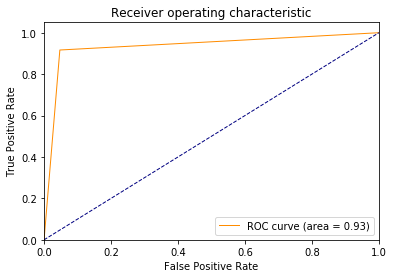

___________________________________________


Processing for ----  identity_hate
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1982
          1       0.91      0.84      0.87       314

avg / total       0.97      0.97      0.97      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  89.42320476649786 % identity_hate


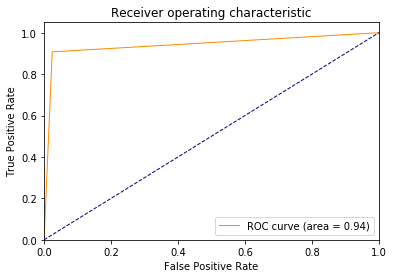

___________________________________________




In [35]:
LinearSVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', dual=False), cv=5), n_jobs=1)),
            ])
for category in class_names:
    print('Processing for ---- ',category)
    # train the model using X_dtm & y
    LinearSVC_pipeline.fit(X_train, train[category])
    prediction = LinearSVC_pipeline.predict(X_test)
    print ("Following is the Classification report - ")
    print(classification_report(test[category], prediction))
    probabilities = LinearSVC_pipeline.predict_proba(testDataSet)
    print ("Testing Comment --- ", testDataSet[0] )
    print ("The above testing comment is " ,probabilities[0][1] * 100,"%", category)
    
    fpr, tpr, thresholds = roc_curve(prediction, test[category])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw=1
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print ("___________________________________________")
    print ("\n")
    

Processing for --- toxic
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.88      0.98      0.92      1173
          1       0.97      0.85      0.91      1123

avg / total       0.92      0.92      0.92      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  78.70221941295426 % toxic


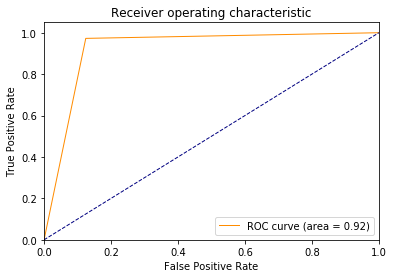

___________________________________________


Processing for --- severe_toxic
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      1916
          1       0.78      0.16      0.27       380

avg / total       0.84      0.85      0.81      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  22.750304283584406 % severe_toxic


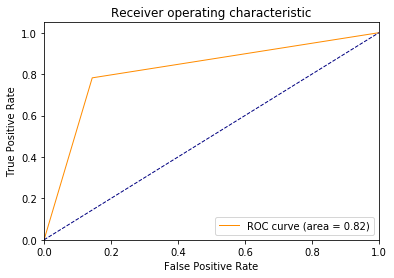

___________________________________________


Processing for --- obscene
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.82      0.99      0.90      1429
          1       0.98      0.63      0.77       867

avg / total       0.88      0.86      0.85      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  69.44597825912618 % obscene


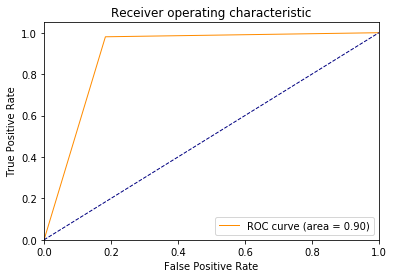

___________________________________________


Processing for --- threat
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2172
          1       1.00      0.01      0.02       124

avg / total       0.95      0.95      0.92      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  9.031973163069464 % threat


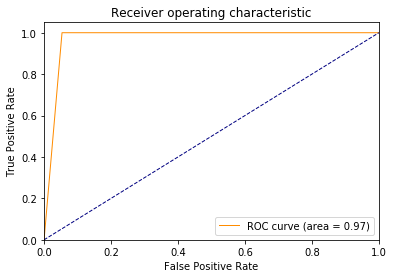

___________________________________________


Processing for --- insult
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.79      0.97      0.87      1428
          1       0.92      0.58      0.71       868

avg / total       0.84      0.82      0.81      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  66.98371762491193 % insult


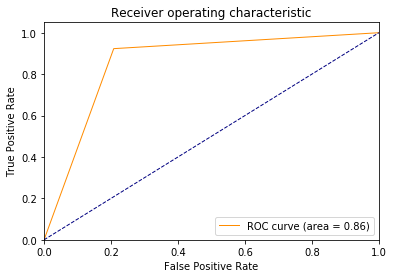

___________________________________________


Processing for --- identity_hate
Following is the Classification report - 
             precision    recall  f1-score   support

          0       0.87      1.00      0.93      1982
          1       0.95      0.07      0.12       314

avg / total       0.88      0.87      0.82      2296

Testing Comment ---  yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time
The above testing comment is  26.573747406865206 % identity_hate


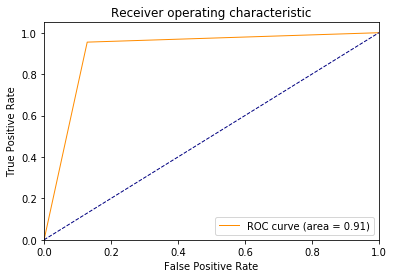

___________________________________________




In [36]:
Logistic_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(C=0.1, solver='sag'), n_jobs=1)),
            ])
fpr = dict()
tpr = dict()
roc_auc = dict()
for category in class_names:
    print("Processing for ---", category)
    Logistic_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = Logistic_pipeline.predict(X_test)
    print ("Following is the Classification report - ")
    print(classification_report(test[category], prediction))
    probabilities = Logistic_pipeline.predict_proba(testDataSet)
    print ("Testing Comment --- ", testDataSet[0] )
    print ("The above testing comment is " ,probabilities[0][1] * 100,"%", category)
    fpr, tpr, thresholds = roc_curve(prediction, test[category])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw=1
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print ("___________________________________________")
    print ("\n")
